In [1]:
# json 내 좌표대로 이미지를 자르고 ImageDataGenerator로 데이터를 증가시켰다 acc 0.7822 ->  오히려 떨어짐??
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [3]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/aihub_test (2).zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [4]:
train_dir = os.path.join('/content/aihub_test/new_dataset')
labels = os.listdir(os.path.join(os.getcwd(), "/content/aihub_test/new_dataset")) # 항목이름 리스트 반환

In [5]:
labels

['plastic', 'can', 'pet', 'styrofoam']

In [6]:
for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "plastic":	 837
Images of label "can":	 1085
Images of label "pet":	 1255
Images of label "styrofoam":	 1505


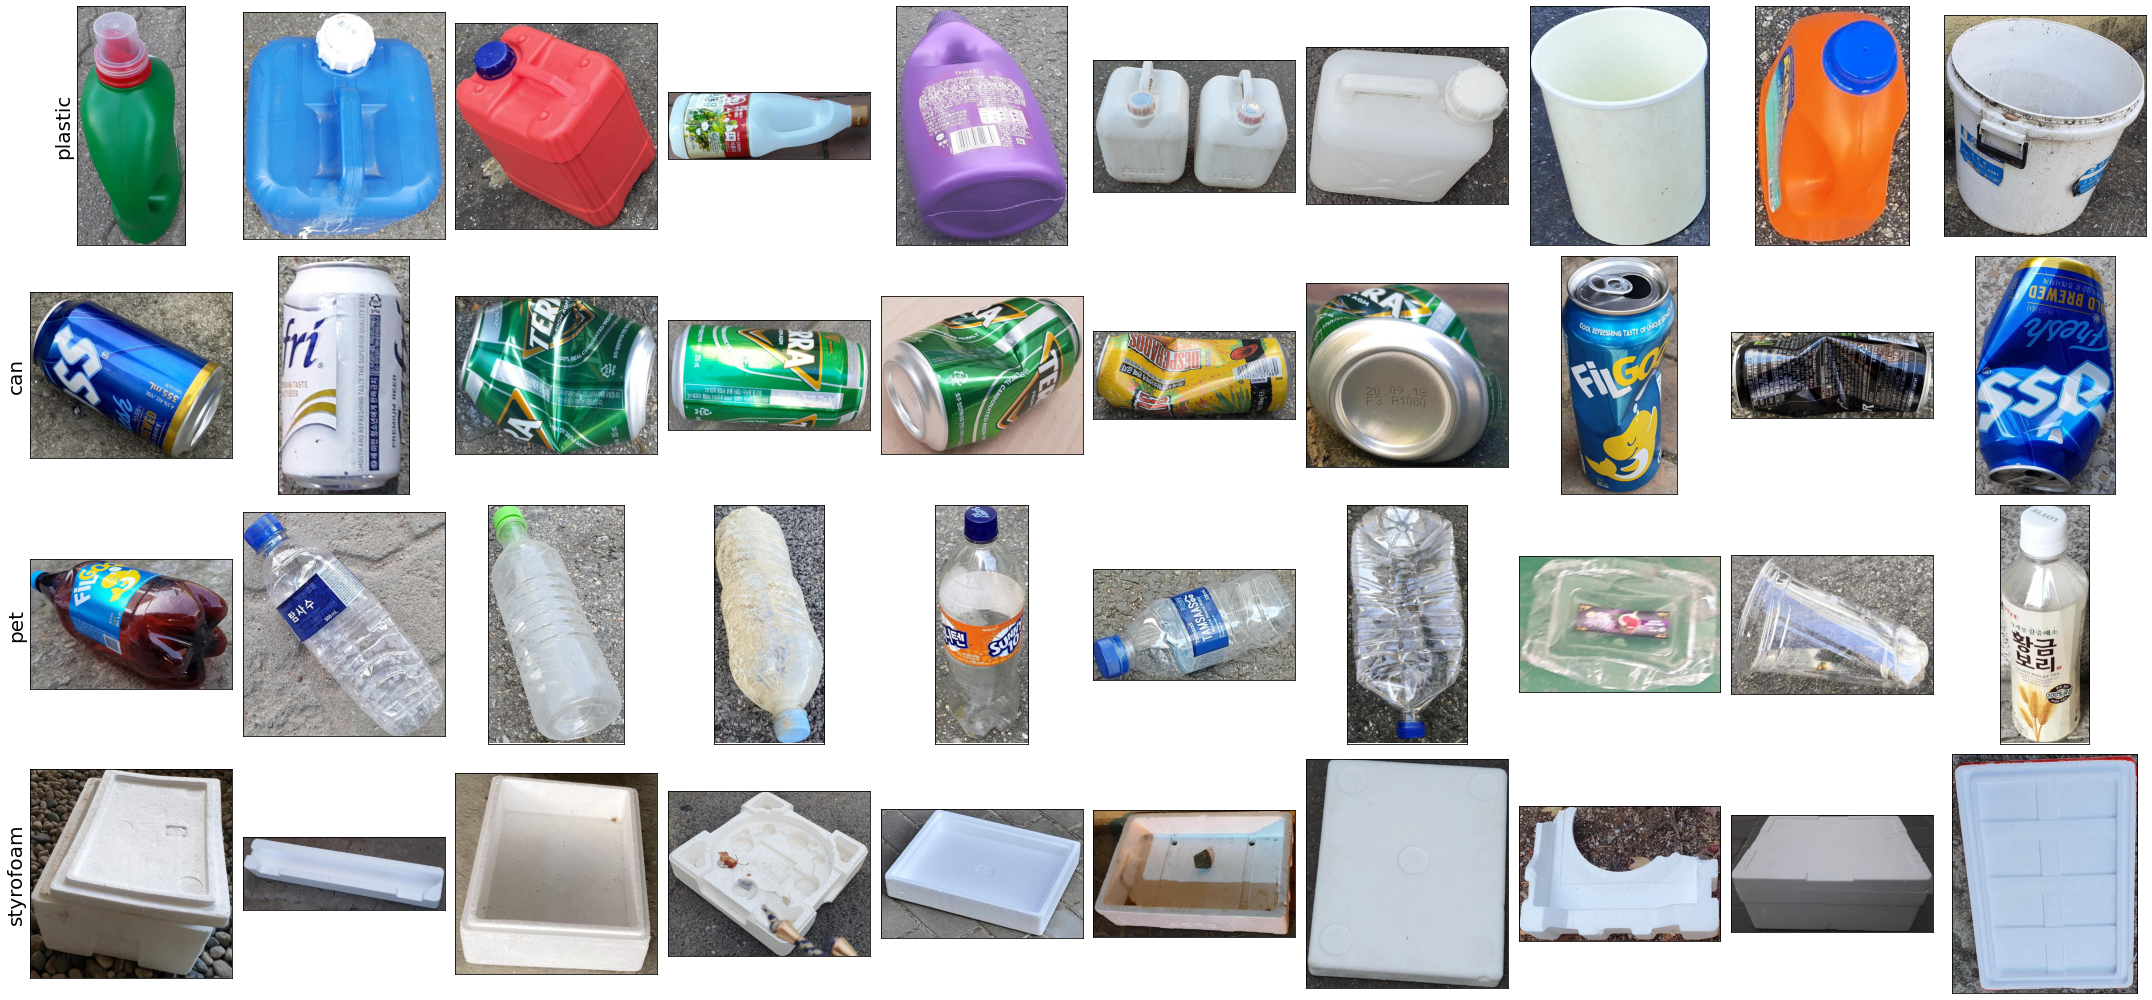

In [8]:
plt.figure(figsize=(30,14))

for i in range(4):
    directory = os.path.join(train_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(4, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 512, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 382, 510, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 380, 508, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 380, 508, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 190, 254, 32)     0         
 )                                                               
                                                        

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = 0.0001), metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True, # ImageDataGenerator 클래스로 이미지 증강(augment)
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255., 
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')

Found 3746 images belonging to 4 classes.
Found 936 images belonging to 4 classes.


In [12]:
# 정확도가 높으면 훈련 종료

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [13]:
history = model.fit(train_generator, epochs=5, verbose=1, validation_data=validation_generator, callbacks=[callbacks])

Epoch 1/5
118/118 [==============================] - 353s 3s/step - loss: 1.5872 - accuracy: 0.5606 - val_loss: 4.2059 - val_accuracy: 0.3462
Epoch 2/5
118/118 [==============================] - 301s 3s/step - loss: 1.0469 - accuracy: 0.6308 - val_loss: 2.7322 - val_accuracy: 0.4103
Epoch 3/5
118/118 [==============================] - 335s 3s/step - loss: 0.8566 - accuracy: 0.6831 - val_loss: 2.2175 - val_accuracy: 0.3632
Epoch 4/5
118/118 [==============================] - 297s 3s/step - loss: 0.7501 - accuracy: 0.7149 - val_loss: 1.3787 - val_accuracy: 0.5288
Epoch 5/5
118/118 [==============================] - 297s 3s/step - loss: 0.7171 - accuracy: 0.7250 - val_loss: 4.7427 - val_accuracy: 0.2479


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


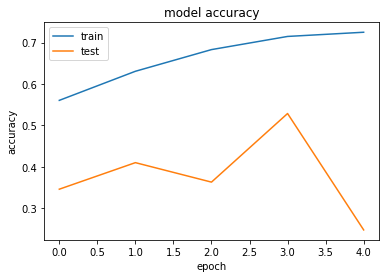

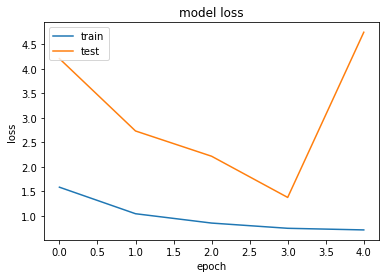

In [14]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()